In [1]:
import csv
import cv2
import numpy as np
import tensorflow as tf
import random
from PIL import Image

In [2]:
lines = []

with open("./train_data/track_1_normal/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
            lines.append(line)

In [3]:
images = []
measurements = []
correction = [0, 0.2, -0.2]

for line in lines:
    measurement = float(line[3])
    if(measurement > -0.05 and measurement < 0.05 and random.random() > 0.4):
        continue
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1]
        current_path = './train_data/track_1_normal/IMG/' + filename
        #print('debugx', current_path)
        image = Image.open(current_path)
        image = np.array(image.convert('YCbCr'))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        images.append(image)
        measurements.append(measurement + correction[i])

In [4]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1))
    augmented_measurements.append(measurement*-1.0)

(array([  2.06515993e-02,   2.75354657e-03,   1.37677328e-03,
          8.26063970e-03,   0.00000000e+00,   1.37677328e-03,
          0.00000000e+00,   0.00000000e+00,   2.47819191e-02,
          2.61586924e-02,   1.10141863e-02,   3.44193321e-02,
          6.33315711e-02,   1.37677328e-02,   9.63741299e-03,
          5.09406115e-02,   5.09406115e-02,   1.01881223e-01,
          1.06011543e-01,   1.65212794e-01,   1.84487620e-01,
          1.15648956e-01,   1.29416689e-01,   1.44561195e-01,
          1.66589567e-01,   1.81734073e-01,   2.38181778e-01,
          2.65717244e-01,   3.27672042e-01,   3.41439774e-01,
          3.04266896e-01,   3.05643669e-01,   4.68102917e-01,
          4.17162305e-01,   4.30930038e-01,   5.98896379e-01,
          6.47083443e-01,   6.15417658e-01,   8.88018768e-01,
          7.66862719e-01,   6.15417658e-01,   3.45707772e+00,
          5.85128646e-01,   8.49469116e-01,   1.07939025e+00,
          9.21061327e-01,   1.02844964e+00,   1.13996828e+00,
        

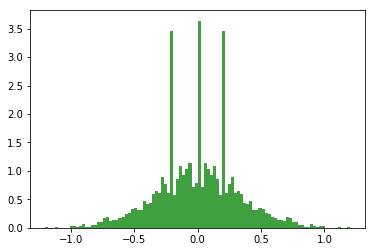

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(augmented_measurements, 100, normed=1, facecolor='green', alpha=0.75)

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

dropout_rate=0

model = Sequential()
model.add(Lambda(lambda x: x /255.0 - 0.5, input_shape=(160,320,3)))
# input 3@160x320
model.add(Cropping2D(cropping=((70,25), (0,0))))
# input 3@65x320
model.add(Convolution2D(24, 5, 5, activation="relu", subsample=(2,2)))
# input 24@31x158
model.add(Convolution2D(36, 5, 5, activation="relu", subsample=(2,2)))
# input 36@14x77
model.add(Convolution2D(48, 5, 5, activation="relu", subsample=(2,2)))
# input 48@5x37
model.add(Convolution2D(64, 3, 3, activation="relu"))
# input 64@3x35
model.add(Convolution2D(64, 3, 3, activation="relu"))
# input 64@1x32
model.add(Flatten())
model.add(Dropout(dropout_rate))
model.add(Dense(1164))
model.add(Dropout(dropout_rate))
model.add(Dense(100))
model.add(Dropout(dropout_rate))
model.add(Dense(50))
model.add(Dropout(dropout_rate))
model.add(Dense(10))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

Using TensorFlow backend.


In [7]:
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=3)

model.save('model.h5')

Train on 24211 samples, validate on 6053 samples
Epoch 1/3
24211/24211 [==============================] - 49s - loss: 0.0475 - val_loss: 0.0475
Epoch 2/3
24211/24211 [==============================] - 45s - loss: 0.0330 - val_loss: 0.0478
Epoch 3/3
24211/24211 [==============================] - 45s - loss: 0.0253 - val_loss: 0.0480s: 


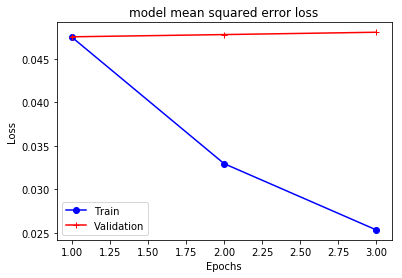

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo-', label='Train')
plt.plot(epochs, val_loss_values, 'r+-', label='Validation')
plt.xlabel('Epochs')
plt.title('model mean squared error loss')
plt.ylabel('Loss')
plt.legend()
plt.show()